> In this file all the SIFT implementations and code is documented. All of the images and files that are used in the report using SIFT can also be found in this code. Each piece of code in this markdown has its own usecases and the explanation on what it does can be found in the markdowns above each piece of code and also with comments in between lines of code.


In [2]:
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from matplotlib.image import imread

Get table is a helper function that is needed to create a nice looking table used in the final report for our results using pandas dataframe


In [3]:
# Standard function we used in more programs to create a nice table using pandas df
def get_table(sims):
    """
    This function takes the output produced by either the compute_similarities 
    or compute_similarities_testsets function, and returns a pandas dataframe/table 
    and also saves it in excel.
    """
    
    data = {}
    rows = []

    for (key1, key2), value in sims.items():
        file1 = os.path.basename(key1).split('.')[0]
        file2 = os.path.basename(key2).split('.')[0]
        
        if file1 not in data:
            data[file1] = []
        if file2 not in rows:
            rows.append(file2)
        
        value = np.round(value, 3)
        data[file1].append(value)
        
    data = {key: value for key, value in sorted(data.items())}
    rows = sorted(rows)
    rows_indices_begin = list(range(len(rows)))
    data_values = list(data.values())
    rows_indices_end = sorted(rows_indices_begin, key=lambda i: rows[i])
    
    for key, value in data.items():
        new_value = []
        for i in rows_indices_end:
            new_value.append(value[i])
        data[key] = new_value
    
    df = pd.DataFrame(data, index=rows)
    return df.T

Code below is our similarity calculator for SIFT

In [4]:
def sift_similarity(img1, img2):
    """
    This function takes 2 images and calculates the similarity using SIFT keypoints.
    """
    sift = cv2.SIFT_create()
    # Find all SIFT keypoints
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    # If no keypoints are found return a similratity of 0.
    if des1 is None or des2 is None:
        return 0.0

    # FLANN is an algorithm to find matches of keypoints between the two images
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)

    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1, des2, k=2)

    # Out of all FLANN matches we find the best matches using Lowe's ratio
    good_matches = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)
    
    # If there are very few matches we return a similarity of 0
    if len(good_matches) < 5:
        return 0.0

    src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 2)

    # Using RANSAC we find the inliers within a distance of 10 to find the matches and calculate the similarity.
    H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 10.0)
    matches_mask = mask.ravel().tolist()

    num_inliers = np.sum(matches_mask)
    num_matches = len(good_matches)
    
    # Similarity is the amount of actual matches found by ransac divided by all good matches.
    similarity_percentage = (num_inliers / num_matches) * 100
    return similarity_percentage

> Code below creates the table of similarities for our own testset.

Needed files for it to work:\
nk_testset\
nk_testset_no_back\
munich_testset\
munich_testset_no_back


In [5]:
def compute_similarities_testsets(munich_testset, nk_testset, 
                                  munich_path="munich_testset", 
                                  nk_path="nk_testset"):
    """
    Computes similarities between images from Munich and NK test sets using ORB features.
    """
    # Create an empty dictionary
    similarities = {}

    # Loop through all NK images
    for nk_img in nk_testset:
        nk_img_path = os.path.join(nk_path, nk_img)
        try:
            nk_img = cv2.imread(nk_img_path, cv2.IMREAD_GRAYSCALE)
            if nk_img is None:
                raise ValueError(f"Image at {nk_img_path} could not be loaded.")
        except ValueError as e:
            print(e)
            continue

        # Loop through all munich images
        for munich_img in munich_testset:
            munich_img_path = os.path.join(munich_path, munich_img)
            try:
                munich_img = cv2.imread(munich_img_path, cv2.IMREAD_GRAYSCALE)
                if munich_img is None:
                    raise ValueError(f"Image at {munich_img_path} could not be loaded.")
            except ValueError as e:
                print(e)
                continue
            # Create all matches and save them in the dictionary
            similarity = sift_similarity(nk_img, munich_img)
            similarities[(nk_img_path, munich_img_path)] = similarity
        
    return similarities

# All paths to the corresponding directories
nk_path = "nk_testset"
munich_path = "munich_testset"
nk_path_no_back = "nk_testset_no_back"
munich_path_no_back = "munich_testset_no_back"

if not os.path.exists(nk_path):
    raise FileNotFoundError(f"The path {nk_path} does not exist.")
if not os.path.exists(munich_path):
    raise FileNotFoundError(f"The path {munich_path} does not exist.")

nk_testset = os.listdir(nk_path)
munich_testset = os.listdir(munich_path)
nk_testset_no_back = os.listdir(nk_path_no_back)
munich_testset_no_back = os.listdir(munich_path_no_back)

# Find all the 25 matches from the testset and create the table.
print("25 testset matches with regular background")
sims = compute_similarities_testsets(munich_testset, nk_testset, munich_path, nk_path)
get_table(sims)

25 testset matches with regular background


,card_table_mccp,chair_mccp,cupboard_mccp,dresser_mccp,table_mccp
card_table_nk,38.462,0.000,55.556,0.000,0.000
chair_nk,36.842,35.714,37.288,24.390,51.587
cupboard_nk,26.667,38.889,59.135,29.310,46.023
dresser_nk,30.000,18.605,29.167,23.810,40.404
table_nk,35.897,33.333,32.353,28.125,40.000


Above are the scores on the testset for SIFT with the background. 

Below are the scores without the background that was created with our background removal implementation.

In [6]:
# Find all the 25 matches from the testset with no background and create the table.
print("25 testset matches with background removal")
sims = compute_similarities_testsets(munich_testset_no_back, nk_testset_no_back, munich_path_no_back, nk_path_no_back)
get_table(sims)

25 testset matches with background removal


,card_table_mccp,chair_mccp,cupboard_mccp,dresser_mccp,table_mccp
card_table_nk,0.000,0.000,0.000,57.143,0.000
chair_nk,33.333,31.579,31.818,25.000,52.632
cupboard_nk,43.269,36.923,41.667,25.862,58.261
dresser_nk,39.024,22.727,43.478,20.339,31.343
table_nk,42.105,35.294,46.154,33.333,31.818


> Code below is to match SIFT with entire dataset. We only look at the first 50 images in this test scenario as SIFT just takes way too long to compute.

Input image can be changed.\
Munich database needed to check the similarities. (SIFT does not work very well)

In [7]:
def compute_similarities(nk_img_path, munich_imgs, path):
    """
    This function takes three arguments: 
    - nk_img, which is a single image from the nk collection. 
    - munich_imgs, this contains all images from the Munich Database. 
    - path, this is the path to the gray scaled Munich Database.
    
    It then computes the feature descriptor for the nk collection image and all the images in the \
    Munich Database. Afterwards takes the dot-product to get the dot-product similiarity. It then \
    saves the similarity and the two images as key-value pairs in a dictionary. 
    """
    
    nk_img = cv2.imread(nk_img_path, cv2.IMREAD_GRAYSCALE)
    similarities = {}
    i = 0
    
    for img_name in munich_imgs:
        if i == 50:
            break
        if i % 10 == 0:
            print(i)
        i += 1
        img_path = os.path.join(path, img_name)
        munich_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        if nk_img is not None and munich_img is not None:
            similarity = sift_similarity(nk_img, munich_img)
            nk_img_name = os.path.basename(nk_img_path)
            munich_img_name = os.path.basename(img_path)
            similarities[(nk_img_name, munich_img_name)] = similarity

    return similarities

# INPUT IMAGE, can change to test other images
nk_img = "nk_testset/chair_nk.jpg"

# entire munich database
munich_imgs = os.listdir("scraped_images_grayscaled_big")
path = "scraped_images_grayscaled_big"

# Only tested on first 50 images which already took 22 seconds. for 47.000 images this would take 5+ hours.
similarities = compute_similarities(nk_img, munich_imgs, path)

0
10
20
30
40


> Code below actually shows the top 10 highest similarities and prints these images with all corresponding data.

This only looks at the first 50 images from the large dataset.
We are already getting high similarities of 79% for our highest rank that looks nothing like the chair.
As this already took 20 seconds for only 50 images, doing this for the entire dataset would take 5 hours and too long.
Thats why we dropped SIFT.

Top 10 similar images for NK image 'chair_nk.jpg':


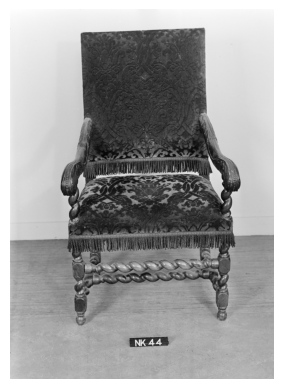

Munich image '0705_4246-21_id=cp160866_badv.jpg' (Similarity: 77.19298245614034)


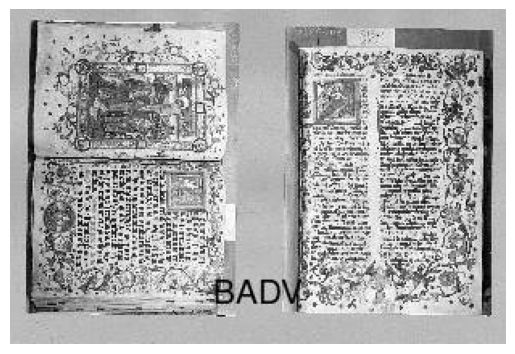

Munich image '1669_19938-3_id=cp146082_badv.jpg' (Similarity: 72.5)


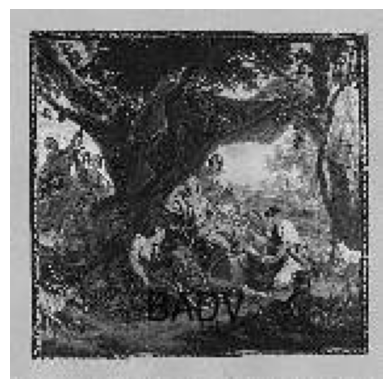

Munich image '2076_41158_id=cp159139_badv.jpg' (Similarity: 66.97247706422019)


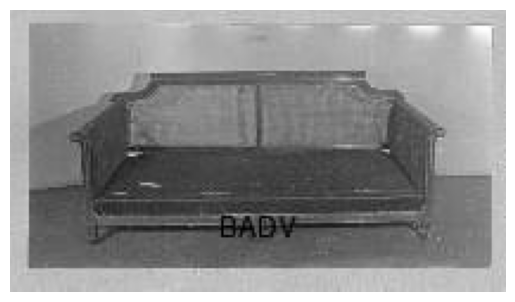

Munich image '1687_20050_id=cp146453_badv.jpg' (Similarity: 59.45945945945946)


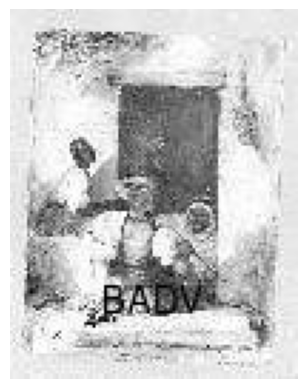

Munich image '1893_31894_id=cp154490_badv.jpg' (Similarity: 57.57575757575758)


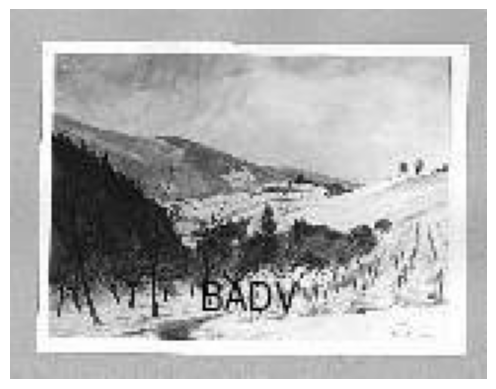

Munich image '0327_1595-5_id=cp143235_badv.jpg' (Similarity: 57.14285714285714)


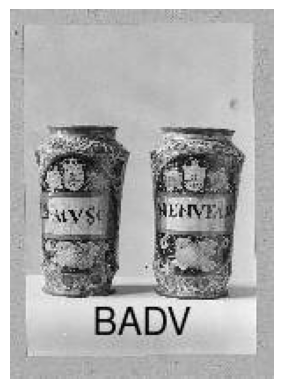

Munich image '2052_38461_id=cp158127_badv.jpg' (Similarity: 56.36363636363636)


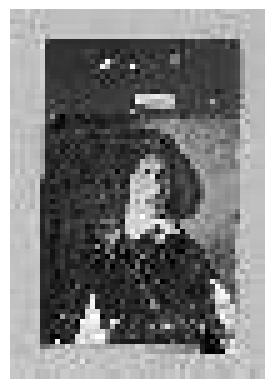

Munich image '1825_26305-86_id=cp151953_badv.jpg' (Similarity: 51.63934426229508)


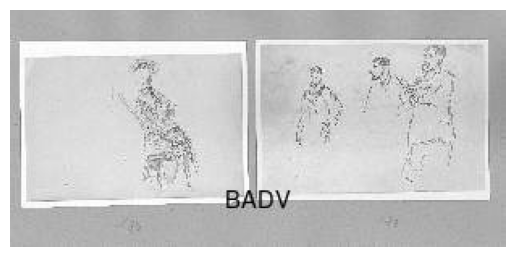

Munich image '1028_7908-44_id=cp172434_badv.jpg' (Similarity: 51.21951219512195)


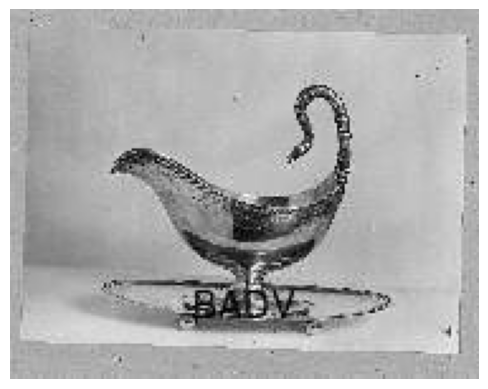

Munich image '2236_45681_id=cp163945_badv.jpg' (Similarity: 50.0)


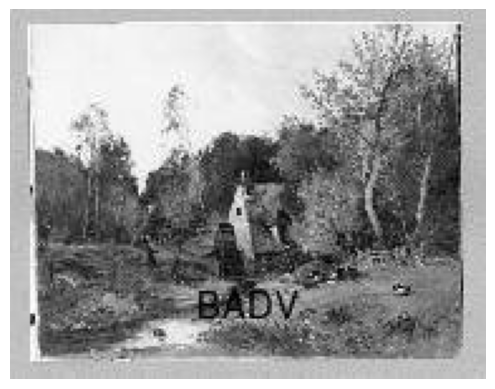

In [8]:
def get_top_10_similarities(similarities):
    """
    Get the top 10 highest similarity values for each NK image from the similarities dictionary.
    
    Parameters:
    - similarities: A dictionary where keys are (NK image name, Munich image name) tuples
                    and values are similarity scores.
                    
    Returns:
    - A dictionary where keys are NK image names and values are lists of tuples
      (Munich image name, similarity) sorted by similarity in descending order.
    """
    top_10_similarities = {}
    
    for nk_img_name in set(key[0] for key in similarities.keys()):
        # Filter similarities for current NK image
        nk_similarities = [(munich_img_name, similarity) for (nk, munich_img_name), similarity in similarities.items() if nk == nk_img_name]
        
        # Sort by similarity in descending order
        sorted_similarities = sorted(nk_similarities, key=lambda x: x[1], reverse=True)
        
        # Get top 10 similarities
        top_10_similarities[nk_img_name] = sorted_similarities[:10]
    
    return top_10_similarities

def display_image(image_path):
    image = imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

def display_nk_image(nk_img_name):
    image_path = f"{nk_path}/{nk_img_name}"
    image = imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

top_10 = get_top_10_similarities(similarities)
for nk_img_name, similar_images in top_10.items():
    print(f"Top 10 similar images for NK image '{nk_img_name}':")
    display_nk_image(nk_img_name)
    for munich_img_name, similarity in similar_images:
        image_path = f"scraped_images_grayscaled_big/{munich_img_name}"
        print(f"Munich image '{munich_img_name}' (Similarity: {similarity})")
        display_image(image_path)

Some keypoint visualizations used in the final report can be found below

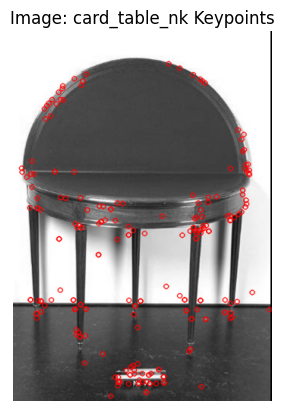

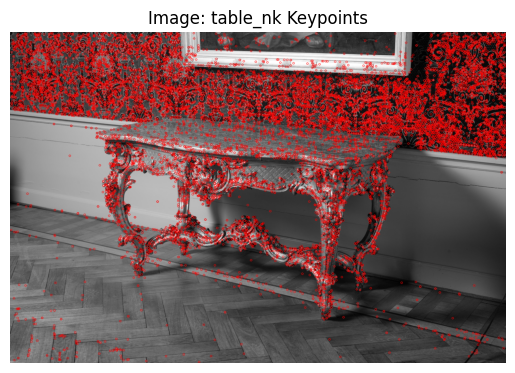

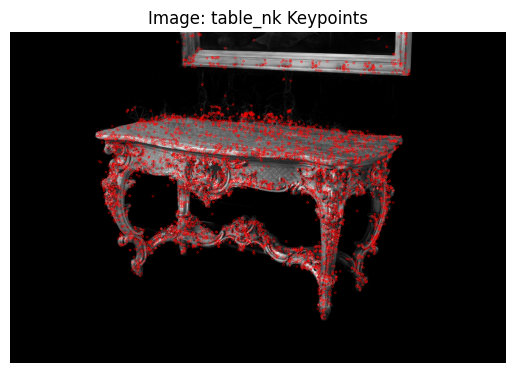

In [10]:
def visualize_keypoints(image_path):
    # Load the image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError("The image path is invalid.")

    sift = cv2.SIFT_create()

    # Detect keypoints and descriptors with SIFT
    kp, des = sift.detectAndCompute(img, None)
    len(kp)
    # Draw keypoints on the image
    img_with_keypoints = cv2.drawKeypoints(img, kp, None, color=(255, 0, 0), flags=cv2.DrawMatchesFlags_DEFAULT)

    # Display the image with keypoints
    plt.imshow(img_with_keypoints, cmap='gray')
    plt.title(f'Image: {image_name(image_path)} Keypoints')
    plt.axis('off')
    plt.show()

def image_name(image_path):
    return os.path.splitext(os.path.basename(image_path))[0]

visualize_keypoints("nk_testset/card_table_nk.png")
visualize_keypoints("nk_testset/table_nk.jpg")
visualize_keypoints("nk_testset_no_back/table_nk.jpg")